In [119]:
import warnings

warnings.filterwarnings('ignore')

In [120]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

In [121]:
print(tf.__version__)

2.10.0-dev20220714


In [122]:
import logging

logging.getLogger("tensorflow").setLevel(logging.ERROR)

In [123]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [124]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


In [128]:
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

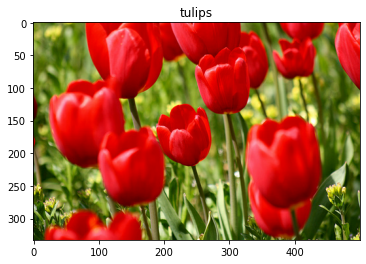

In [129]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [130]:
IMG_SIZE = 180

# 이미지 크기(180x180) 및 배율 조정(/255.)
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
    layers.experimental.preprocessing.Rescaling(1. / 255)
])

Min and max pixel values: 0.0 1.0


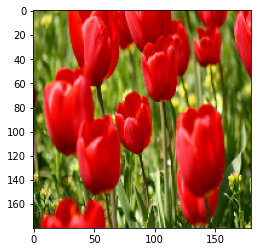

In [131]:
# 이미지 크기가 180x180으로 변경됨
result = resize_and_rescale(image)
_ = plt.imshow(result)

# 픽셀이 0과 1사이에 존재하고 있음
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

In [132]:
# 전처리 레이어를 사용한 데이터 증강
data_augmentation = tf.keras.Sequential([
    # training 중에 이미지를 임의로 뒤집는 전처리 layer
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    # training 중에 이미지를 임의로 회전시키는 전처리 layer
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [133]:
# Add the image to a batch
image = tf.expand_dims(image, 0)

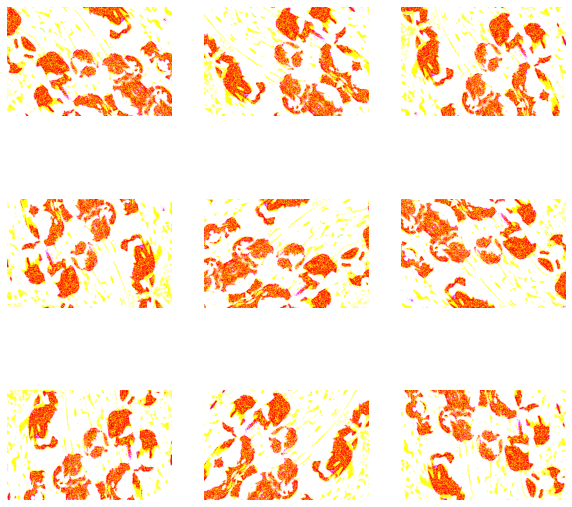

In [134]:
# 버전 문제로 경고 표시 나오고 스케일링 요구하는 듯 함.
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = data_augmentation(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0])
    plt.axis("off")

In [135]:
# 모델 생성
model = tf.keras.Sequential([
    # 크기 및 배율 조정
    resize_and_rescale,
    # 데이터 증강
    data_augmentation,
    # cnn
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
])

In [136]:
# Dataset.map을 사용하여 증강 이미지 배치를 생성하는 데이터세트를 만듬
aug_ds = train_ds.map(lambda x, y: (resize_and_rescale(x, training=True), y))

In [137]:
batch_size = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE


# 데이터세트에 전처리 레이어 적용하기
def prepare(ds, shuffle=False, augment=False):
    # 모든 데이터셋의 크기 조정 및 재조정
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y),
                num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(1000)

    # 모든 데이터 세트 배치
    ds = ds.batch(batch_size)

    # training 세트에만 DA 사용
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)

    # 모든 데이터 세트에서 버퍼링된 영역 지정 사용
    return ds.prefetch(buffer_size=AUTOTUNE)

In [138]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

In [139]:
# 모델 정의
model = tf.keras.Sequential([
    # cnn
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    # 완전연결층
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [140]:
# 모델 설정
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [141]:
# 모델 훈련
epochs = 5
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/5
92/92 [==============================] - 21s 218ms/step - loss: 1.3009 - accuracy: 0.4366 - val_loss: 1.1073 - val_accuracy: 0.5749
Epoch 2/5
92/92 [==============================] - 22s 238ms/step - loss: 1.0565 - accuracy: 0.5807 - val_loss: 0.9357 - val_accuracy: 0.6621
Epoch 3/5
92/92 [==============================] - 26s 273ms/step - loss: 0.9576 - accuracy: 0.6233 - val_loss: 0.9282 - val_accuracy: 0.6567
Epoch 4/5
92/92 [==============================] - 25s 269ms/step - loss: 0.8914 - accuracy: 0.6516 - val_loss: 0.8517 - val_accuracy: 0.6485
Epoch 5/5
92/92 [==============================] - 25s 268ms/step - loss: 0.8369 - accuracy: 0.6727 - val_loss: 0.8506 - val_accuracy: 0.6621


In [142]:
loss, acc = model.evaluate(test_ds)
print("Accuracy", acc)

12/12 [==============================] - 1s 42ms/step - loss: 0.7787 - accuracy: 0.7221
Accuracy 0.7220708727836609


In [143]:
# 이미지 색상 반전
def random_invert_img(x, p=0.5):
    if tf.random.uniform([]) < p:
        x = (255 - x)
    else:
        x

    return x

In [144]:
# 무작위로 이미지 색상 반전
def random_invert(factor=0.5):
    return layers.Lambda(lambda x: random_invert_img(x, factor))


random_invert = random_invert()

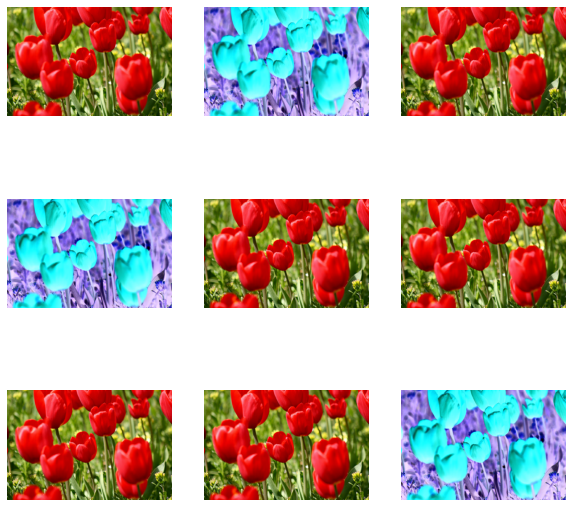

In [145]:
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = random_invert(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0].numpy().astype("uint8"))
    plt.axis("off")

In [146]:
# 무작위 색상 반전
class RandomInvert(layers.Layer):

    def __init__(self, factor=0.5, **kwargs):
        super().__init__(**kwargs)
        self.factor = factor

    def call(self, x):
        return random_invert_img(x)

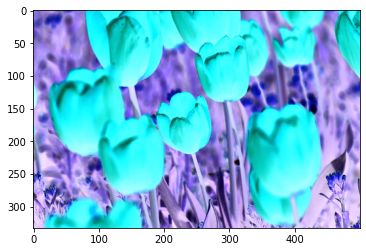

In [148]:
_ = plt.imshow(RandomInvert()(image)[0])

In [149]:
# 새로 데이터 세트 정의
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

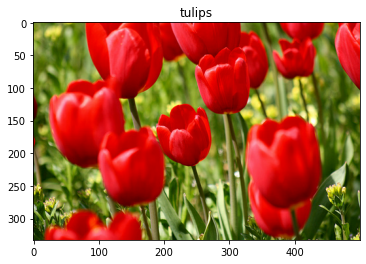

In [150]:
image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [151]:
# 원본 이미지, 데이터 증강 이미지 출력
def visualize(original, augmented):
    fig = plt.figure()
    plt.subplot(1, 2, 1)
    plt.title('Original image')
    plt.imshow(original)

    plt.subplot(1, 2, 2)
    plt.title('Augmented image')
    plt.imshow(augmented)

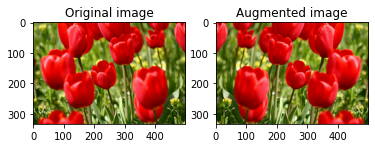

In [152]:
# 이미지 뒤집기
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

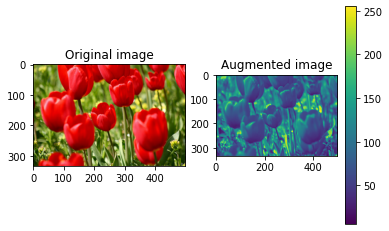

In [153]:
# 이미지 회색조 만들기
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
_ = plt.colorbar()

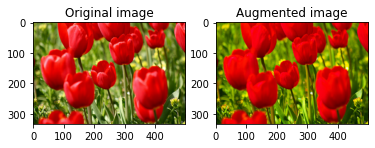

In [154]:
# 이미지 포화시키기
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

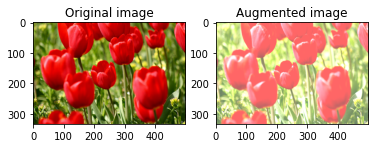

In [155]:
# 이미지 밝기 변경하기
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

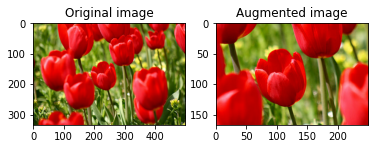

In [156]:
# 이미지 중앙 자르기
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image, cropped)

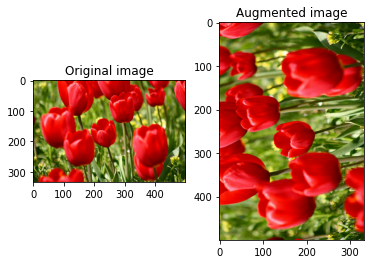

In [157]:
# 이미지 회전하기
rotated = tf.image.rot90(image)
visualize(image, rotated)

In [158]:
# 스케일링 함수
def resize_and_rescale(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (image / 255.0)

    return image, label


# 데이터 증강 함수
def augment(image, label):
    image, label = resize_and_rescale(image, label)
    # Add 6 pixels of padding
    image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 6, IMG_SIZE + 6)
    # Random crop back to the original size
    image = tf.image.random_crop(image, size=[IMG_SIZE, IMG_SIZE, 3])
    image = tf.image.random_brightness(image,
                                       max_delta=0.5)  # Random brightness
    image = tf.clip_by_value(image, 0, 1)
    return image, label

In [159]:
# 훈련 데이터세트 증강
train_ds = (train_ds.shuffle(1000).map(
    augment, num_parallel_calls=AUTOTUNE).batch(batch_size).prefetch(AUTOTUNE))

# 검증 데이터세트 스케일링
val_ds = (val_ds.map(
    resize_and_rescale,
    num_parallel_calls=AUTOTUNE).batch(batch_size).prefetch(AUTOTUNE))

# 훈련 데이터세트 스케일링
test_ds = (test_ds.map(
    resize_and_rescale,
    num_parallel_calls=AUTOTUNE).batch(batch_size).prefetch(AUTOTUNE))

In [160]:
# 모델 훈련
epochs = 5
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/5
92/92 [==============================] - 29s 313ms/step - loss: 0.9374 - accuracy: 0.6379 - val_loss: 0.8062 - val_accuracy: 0.7057
Epoch 2/5
92/92 [==============================] - 33s 357ms/step - loss: 0.8182 - accuracy: 0.6798 - val_loss: 0.7671 - val_accuracy: 0.6948
Epoch 3/5
92/92 [==============================] - 33s 355ms/step - loss: 0.7255 - accuracy: 0.7272 - val_loss: 0.7530 - val_accuracy: 0.7057
Epoch 4/5
92/92 [==============================] - 32s 345ms/step - loss: 0.6148 - accuracy: 0.7711 - val_loss: 0.7683 - val_accuracy: 0.7057
Epoch 5/5
92/92 [==============================] - 32s 352ms/step - loss: 0.4910 - accuracy: 0.8225 - val_loss: 0.8850 - val_accuracy: 0.7030


In [161]:
loss, acc = model.evaluate(test_ds)
print("Accuracy", acc)

12/12 [==============================] - 1s 50ms/step - loss: 0.8614 - accuracy: 0.7112
Accuracy 0.7111716866493225


### 구글에서 튤립이미지 가져와서 모델 예측 시켜보기

In [162]:
from PIL import Image

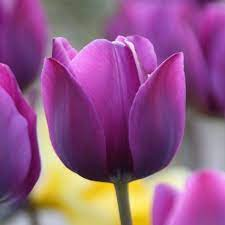

In [163]:
img = Image.open('images/tulip.jpg')
img

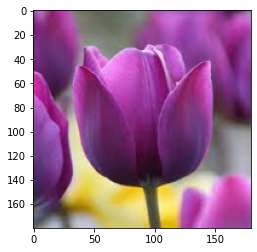

In [164]:
img = img.resize((180, 180))
imgArr = np.array(img)
imgArr = imgArr / 255.
plt.imshow(imgArr)

In [166]:
img_array = tf.expand_dims(imgArr, 0)  # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print("This image most likely belongs to {} with a {:.2f} percent confidence.".
      format(metadata.features['label'].int2str(np.argmax(score)), 100 * np.max(score)))

1/1 [==============================] - 0s 29ms/step
This image most likely belongs to tulips with a 48.11 percent confidence.
